# Import and load

In [1]:
import sys, yaml
sys.path.append('../lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/measured_rates.csv')
for c in df.columns:
    print c

Ci_multi
Ci_multi_err
Ci_single
Ci_single_err
Ci_tot
Ci_tot_err
Ci1_thr
Ci1_thr_err
Ci1_pnr
Ci1_pnr_err
Ci12_thr
Ci12_thr_err
Ci12_pnr
Ci12_pnr_err
Ci2_thr
Ci2_thr_err
Ci2_pnr
Ci2_pnr_err
C1_tot
C1_tot_err
C12
C12_err
C2_tot
C2_tot_err
shg_current
g2_pnr
g2_pnr_err
g2_thr
g2_thr_err


In [3]:
addData = {}

# Efficiency 0-th iteration

### Idler efficiency

By definition $\eta_i$ does not depends on wheather the idler is used as PNR as THR. However there is a lot of correlation between the efficiencies measured in the two modes and wrt the two signals. **This measurment should NOT be considered.**

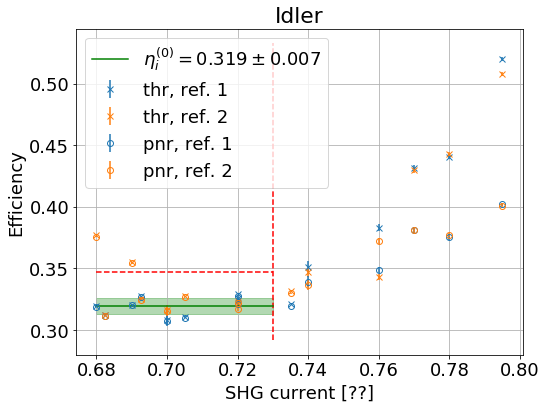

In [4]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
ms = {'thr': 'x', 'pnr': 'o'}
mc = {'1': 'C0', '2':'C1'}

# auxDf = df[df['shg_current'] < 0.8]
for mode in ['thr', 'pnr']:
    for ref in ['1', '2']:
        name = 'eta0_i_{}_r{}'.format(mode, ref)
        
        num = 'Ci{}_{}'.format(ref, mode)
        den = 'C{}_tot'.format(ref)
        df[name] = df[num]/df[den]
        df[name+'_err'] = df[name]*np.hypot(df[num+'_err']/df[num], df[den+'_err']/df[den])
        
        sel = df['shg_current'] < 0.8
        plt.errorbar(df['shg_current'][sel], df[name][sel], yerr=df[name+'_err'][sel],
                     marker=ms[mode], color=mc[ref], 
                     mfc='none', ls='none',
                     label=mode+', ref. '+ref
                    )
        
plt.plot([0.73]*2, plt.ylim(), 'r--')
plt.plot([0.68, 0.73], 2*[0.347], 'r--')

eff = []
for vn in df.columns:
    if not vn.startswith('eta0_i_'):
        continue
    if vn.endswith('_err'): 
        continue
    eff += list(df[vn][df['shg_current'] < 0.73])
eff = np.array(eff)
eff = eff[eff < 0.35]
addData['eta0_i'] = [np.mean(eff), np.std(eff)]
plt.fill_between([0.68, 0.73], 2*[np.mean(eff) + np.std(eff)], 2*[np.mean(eff) - np.std(eff)], color='green', alpha=0.3)
plt.plot([0.68, 0.73], 2*[np.mean(eff)], 'g', label=r'$\eta_i^{{(0)}} = {:.3f} \pm {:.3f}$'.format(*(addData['eta0_i'])))

plt.grid()
plt.title('Idler')
plt.xlabel('SHG current [??]')
plt.ylabel('Efficiency')
plt.legend(loc='best');

### Signal efficiency

We work in the approximation $\mu \ll 1$ that we enforce by requiring the SHG current to be smaller than 0.73. We will verify this at the ext step when computing $\mu$.

We can only use $\eta_s \sim 2C_{is}/C_i$ because $C_{12} \sim \frac{2}{3}\mu^2\eta_1\eta_2$ is quadratic in $\mu$ and retain the dependence when divided by $C_s \sim \frac{\mu\eta_s}{2}$.
Note also that $C_{is}$ is independent from $C_i$ because it has been measured in a separate experiment.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Removing 0 (3.1 sigma)
Removing 0 (8.4 sigma)


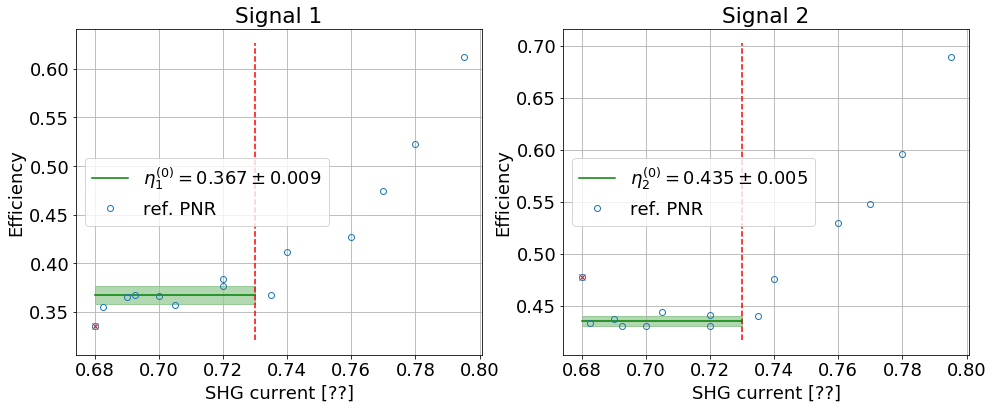

In [5]:
# plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 2, figsize=(16,6))

for i, t in enumerate(['1', '2']):
    df['eta0_{}_rPnr'.format(t)] = 2*df['Ci{}_pnr'.format(t)]/df['Ci_single']

    sel = df['shg_current'] < 0.8
    ax[i].errorbar(df['shg_current'][sel], df['eta0_{}_rPnr'.format(t)][sel],
                         marker='o', color='C0', ls='none', mfc='none',
                         label='ref. PNR'
                        )
    ax[i].plot([0.73]*2, ax[i].get_ylim(), 'r--')
    
    eff = df['eta0_{}_rPnr'.format(t)][df['shg_current'] < 0.73]
    
    idxMax = np.argmax(np.abs(eff - np.percentile(eff, 50)))
#     print 'Leaving out', idxMax
    auxEff = list(eff[:idxMax]) + list(eff[idxMax+1:])
    width = 0.5*(np.percentile(auxEff, 85) - np.percentile(auxEff, 15))
    delta = np.max(np.abs(eff - np.percentile(auxEff, 50)) / width)
    if np.max(delta) > 3:
        print 'Removing {} ({:.1f} sigma)'.format(np.argmax(delta), np.max(delta))
        eff = np.array(auxEff)

        aux = df[df['shg_current'] < 0.73][['shg_current','eta0_{}_rPnr'.format(t)]]
        aux = aux.to_numpy()[np.argmax(delta)]
        ax[i].plot(aux[0], aux[1], 'xr')            
    
#     print 'S{} efficiency (0-th): {:.3f} +/- {:.3f}'.format(t, np.mean(eff), np.std(eff))
    addData['eta0_'+t] = [np.mean(eff), np.std(eff)]
    ax[i].fill_between([0.68, 0.73], 2*[np.mean(eff) + np.std(eff)], 2*[np.mean(eff) - np.std(eff)], color='green', alpha=0.3)
    ax[i].plot([0.68, 0.73], 2*[np.mean(eff)], 'g', label=r'$\eta_{}^{{(0)}} = {:.3f} \pm {:.3f}$'.format(t, *(addData['eta0_'+t])))
    
    ax[i].grid()
    ax[i].set_title('Signal '+t)
    ax[i].set_xlabel('SHG current [??]')
    ax[i].set_ylabel('Efficiency')
    ax[i].legend(loc='best')

In [6]:
for k, v in addData.iteritems():
    addData[k] = [float(x) for x in v]
print addData
with open('../data/efficiencies_estimation.yml', 'w') as dumpFile:
    dumpFile.write(yaml.dump(addData))

{'eta0_2': [0.43523796180169366, 0.005182258933552966], 'eta0_i': [0.31931173659696527, 0.0066173720608280395], 'eta0_1': [0.36724232090004233, 0.009365228154468433]}


# Estimation of $\mu$

We want to get aeasurment of $\mu$ independent from the data used to measure $g_2(0)$. We will measure it only using $R_1$, $R_2$ and $R_{12}$ which should be independent from each other give that $R_{12}$ has been recorded in a separate experiment from $R_1$ and $R_2$.

In [7]:
from spdc_model_utils import countProbaSignal, countProbaIdler
from spdc_model_utils import countProbaS1S2

In [8]:
mu0 = np.array([1.25e-3, 6.26e-3, 1.42e-2, 1.87e-2,1.18e-2, 5.25e-2, 1.36e-1, 3.36e-1,5.11e-1, 7.52e-1 ,1.21 ,1.60,1.83, 2.40, 2.95, 3.47,3.88, 4.52])

In [9]:
mu0.shape

(18,)

In [10]:
df.columns

Index([u'Ci_multi', u'Ci_multi_err', u'Ci_single', u'Ci_single_err', u'Ci_tot',
       u'Ci_tot_err', u'Ci1_thr', u'Ci1_thr_err', u'Ci1_pnr', u'Ci1_pnr_err',
       u'Ci12_thr', u'Ci12_thr_err', u'Ci12_pnr', u'Ci12_pnr_err', u'Ci2_thr',
       u'Ci2_thr_err', u'Ci2_pnr', u'Ci2_pnr_err', u'C1_tot', u'C1_tot_err',
       u'C12', u'C12_err', u'C2_tot', u'C2_tot_err', u'shg_current', u'g2_pnr',
       u'g2_pnr_err', u'g2_thr', u'g2_thr_err', u'eta0_i_thr_r1',
       u'eta0_i_thr_r1_err', u'eta0_i_thr_r2', u'eta0_i_thr_r2_err',
       u'eta0_i_pnr_r1', u'eta0_i_pnr_r1_err', u'eta0_i_pnr_r2',
       u'eta0_i_pnr_r2_err', u'eta0_1_rPnr', u'eta0_2_rPnr'],
      dtype='object')

In [11]:
def _likelihood_()

SyntaxError: invalid syntax (<ipython-input-11-99c78d43a507>, line 1)